# Introduction

AirBnB is a marketplace for short term rentals that allows you to list part or all of your living space for others to rent. You can rent everything from a room in an apartment to your entire house on AirBnB. Because most of the listings are on a short-term basis, AirBnB has grown to become a popular alternative to hotels. The company itself has grown from it's founding in 2008 to a 30 billion dollar valuation in 2016 and is currently worth more than any hotel chain in the world.

One challenge that hosts looking to rent their living space face is determining the optimal nightly rent price. In many areas, renters are presented with a good selection of listings and can filter on criteria like price, number of bedrooms, room type and more. Since AirBnB is a marketplace, the amount a host can charge on a nightly basis is closely linked to the dynamics of the marketplace.

As a host, if we try to charge above market price for a living space we'd like to rent, then renters will select the more affordable alternative living spaces that are similar to our living spacematch our living space's amenities. If we set our nightly rent price too low, we'll miss out on potential revenue.

One strategy we could use is to:

-find a few listings that are similar to ours,
-average the listed price for the ones most similar to ours,
-set our listing price to this calculated average price.

The process of discovering patterns in existing data to make a prediction is called machine learning. In our case, we want to use data on local listings to predict the optimal price for us to set. I will explore a specific machine learning technique called k-nearest neighbors, which mirrors the strategy we just described. Before we dive further into machine learning and k-nearest neighbors, let's get familiar with the dataset we'll be working with.

In this project, I'll be working with Airbnbsdataset from October 3, 2015 on the listings from Washington, D.C., the capital of the United States. 

To make the dataset less cumbersome to work with, we've removed many of the columns in the original dataset and renamed the file to dc_airbnb.csv. Here are the columns we kept:

host_response_rate: the response rate of the host
host_acceptance_rate: number of requests to the host that convert to rentals
host_listings_count: number of other listings the host has
latitude: latitude dimension of the geographic coordinates
longitude: longitude part of the coordinates
city: the city the living space resides
zipcode: the zip code the living space resides
state: the state the living space resides
accommodates: the number of guests the rental can accommodate
room_type: the type of living space (Private room, Shared room or Entire home/apt
bedrooms: number of bedrooms included in the rental
bathrooms: number of bathrooms included in the rental
beds: number of beds included in the rental
price: nightly price for the rental
cleaning_fee: additional fee used for cleaning the living space after the guest leaves
security_deposit: refundable security deposit, in case of damages
minimum_nights: minimum number of nights a guest can stay for the rental
maximum_nights: maximum number of nights a guest can stay for the rental
number_of_reviews: number of reviews that previous guests have left
Let's read the dataset into Pandas and become more familiar with it.

# Read Data 

In [1]:
import pandas as pd
import numpy as np
dc_listings = pd.read_csv("C:/Users/Jennifer/Documents/Python/Data/dc_airbnb.csv")
dc_listings.head()

,id,listing_url,scrape_id,last_scraped,name,summary,space,description,experiences_offered,neighborhood_overview,...,review_scores_value,requires_license,license,jurisdiction_names,instant_bookable,cancellation_policy,require_guest_profile_picture,require_guest_phone_verification,calculated_host_listings_count,reviews_per_month
0,7087327,https://www.airbnb.com/rooms/7087327,20151002231825,2015-10-03,Historic DC Condo-Walk to Capitol!,Professional pictures coming soon! Welcome to ...,NaN,Professional pictures coming soon! Welcome to ...,none,NaN,...,NaN,f,NaN,"DISTRICT OF COLUMBIA, WASHINGTON",f,flexible,f,f,18,NaN
1,975833,https://www.airbnb.com/rooms/975833,20151002231825,2015-10-03,Spacious Capitol Hill Townhouse,NaN,Beautifully renovated Capitol Hill townhouse. ...,Beautifully renovated Capitol Hill townhouse. ...,none,NaN,...,9.0,f,NaN,"DISTRICT OF COLUMBIA, WASHINGTON",f,strict,f,f,1,2.11
2,8249488,https://www.airbnb.com/rooms/8249488,20151002231825,2015-10-03,Spacious/private room for single,This is an ideal room for a single traveler th...,NaN,This is an ideal room for a single traveler th...,none,NaN,...,NaN,f,NaN,NaN,f,flexible,f,f,1,1.00
3,8409022,https://www.airbnb.com/rooms/8409022,20151002231825,2015-10-03,A wonderful bedroom with library,Prime location right on the Potomac River in W...,NaN,Prime location right on the Potomac River in W...,none,NaN,...,NaN,f,NaN,"DISTRICT OF COLUMBIA, WASHINGTON",f,flexible,f,f,1,NaN
4,8411173,https://www.airbnb.com/rooms/8411173,20151002231825,2015-10-03,Downtown Silver Spring,"Hi travellers! I live in this peaceful spot, b...",This is a 750 sq ft 1 bedroom 1 bathroom. Whi...,"Hi travellers! I live in this peaceful spot, b...",none,Silver Spring is booming. You can walk to a n...,...,NaN,f,NaN,NaN,f,flexible,f,f,1,NaN


# Strategy

The strategy we will use is find attributes in the data that related well to a listings price. Then we will group a number of listings with similar attributes and then calculate the average nightly price of these listings and set the average price as the price of our listing.

We will  define what metrics we are going to use. And then we will implement k-nearest algorithm and use it to suggest a price for a new unpriced listing.

First off let's randomize the order of the listings so that we aren't biasing the results to the original order. Additionally lets do some cleaning up

In [2]:
np.random.seed(1)

dc_listings = dc_listings.loc[np.random.permutation(len(dc_listings))]
stripped_commas = dc_listings['price'].str.replace(',', '')
stripped_dollars = stripped_commas.str.replace('$', '')
dc_listings['price'] = stripped_dollars.astype('float')
columns_to_keep = ['host_response_rate', 'host_acceptance_rate', 'host_listings_count',
       'accommodates', 'room_type', 'bedrooms', 'bathrooms', 'beds', 'price',
       'cleaning_fee', 'security_deposit', 'minimum_nights', 'maximum_nights',
       'number_of_reviews', 'latitude', 'longitude', 'city', 'zipcode',
       'state']
dc_listings = pd.DataFrame(dc_listings, columns=columns_to_keep)

print(dc_listings.info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3723 entries, 574 to 1061
Data columns (total 19 columns):
host_response_rate      3289 non-null object
host_acceptance_rate    3109 non-null object
host_listings_count     3723 non-null int64
accommodates            3723 non-null int64
room_type               3723 non-null object
bedrooms                3702 non-null float64
bathrooms               3696 non-null float64
beds                    3712 non-null float64
price                   3723 non-null float64
cleaning_fee            2335 non-null object
security_deposit        1426 non-null object
minimum_nights          3723 non-null int64
maximum_nights          3723 non-null int64
number_of_reviews       3723 non-null int64
latitude                3723 non-null float64
longitude               3723 non-null float64
city                    3723 non-null object
zipcode                 3714 non-null object
state                   3723 non-null object
dtypes: float64(6), int64(5), objec

# Handling missing values

Of the remaining columns, 3 columns have a few missing values (less than 1% of the total number of rows):

bedrooms
bathrooms
beds

Since the number of rows containing missing values for one of these 3 columns is low, we can select and remove those rows without losing much information. There are also 2 columns have a large number of missing values:

cleaning_fee - 37.3% of the rows
security_deposit - 61.7% of the rows
and we can't handle these easily. We can't just remove the rows containing missing values for these 2 columns because we'd miss out on the majority of the observations in the dataset. Instead, let's remove these 2 columns entirely from consideration.

We can also go ahead and remove columns that are not numeric in nature and therefore will not be used in the model

In [3]:
drop_columns = ['room_type', 'city', 'state', 'latitude', 'longitude', 'zipcode', 'host_response_rate', 'host_acceptance_rate', 'host_listings_count']
dc_listings = dc_listings.drop(drop_columns, axis=1)
dc_listings = dc_listings.drop(['cleaning_fee', 'security_deposit'], axis=1)
dc_listings = dc_listings.dropna(axis=0)
print(dc_listings.isnull().sum())


accommodates         0
bedrooms             0
bathrooms            0
beds                 0
price                0
minimum_nights       0
maximum_nights       0
number_of_reviews    0
dtype: int64


# Normalize Columns

You may have noticed that while the accommodates, bedrooms, bathrooms, beds, and minimum_nights columns hover between 0 and 12 (at least in the first few rows), the values in the maximum_nights and number_of_reviews columns span much larger ranges. For example, the maximum_nights column has values as low as 4 and high as 1825, in the first few rows itself. If we use these 2 columns as part of a k-nearest neighbors model, these attributes could end up having an outsized effect on the distance calculations because of the largeness of the values.

For example, 2 living spaces could be identical across every attribute but be vastly different just on the maximum_nights column. If one listing had a maximum_nights value of 1825 and the other a maximum_nights value of 4, because of the way Euclidean distance is calculated, these listings would be considered very far apart because of the outsized effect the largeness of the values had on the overall Euclidean distance. To prevent any single column from having too much of an impact on the distance, we can normalize all of the columns to have a mean of 0 and a standard deviation of 1.

Normalizing the values in each columns to the standard normal distribution (mean of 0, standard deviation of 1) preserves the distribution of the values in each column while aligning the scales. To normalize the values in a column to the standard normal distribution, you need to:

from each value, subtract the mean of the column
divide each value by the standard deviation of the column
Here's the mathematical formula describing the transformation that needs to be applied for all values in a column:

x=x−μσ.

where x is a value in a specific column, mu is the mean of all the values in the column, and sigma is the standard deviation of all the values in the column


In [4]:
normalized_listings = (dc_listings - dc_listings.mean())/(dc_listings.std())
normalized_listings['price'] = dc_listings['price']
print(normalized_listings.head(3))


      accommodates  bedrooms  bathrooms      beds  price  minimum_nights  \
574      -0.596544 -0.249467  -0.439151 -0.546858  125.0       -0.341375   
1593     -0.596544 -0.249467   0.412923 -0.546858   85.0       -0.341375   
3091     -1.095499 -0.249467  -1.291226 -0.546858   50.0       -0.341375   

      maximum_nights  number_of_reviews  
574        -0.016604           4.579650  
1593       -0.016603           1.159275  
3091       -0.016573          -0.482505  


# Introducin Sckit-Learn
In this section of code, I will use the scikit-learn library, which is the most popular machine learning in Python. Scikit-learn contains functions for all of the major machine learning algorithms and a simple, unified workflow. 

The scikit-learn workflow consists of 4 main steps:

instantiate the specific machine learning model you want to use
fit the model to the training data
use the model to make predictions
evaluate the accuracy of the predictions

Now, we can fit the model to the data using the fit method. For all models, the fit method takes in 2 required parameters:

matrix-like object, containing the feature columns we want to use from the training set.
list-like object, containing correct target values.

In [5]:
from sklearn.neighbors import KNeighborsRegressor

In [6]:
train_df = normalized_listings.iloc[0:2792]
test_df = normalized_listings.iloc[2792:]
train_columns = ['accommodates', 'bathrooms']

# Instantiate ML model.
knn = KNeighborsRegressor(n_neighbors=5, algorithm='brute')

# Fit model to data.
knn.fit(train_df[train_columns], train_df['price'])

# Use model to make predictions.
predictions = knn.predict(test_df[train_columns])

# Calculate MSE and RMSE
Inorder to see how our model performed we need to see how far our predictions are from the real results. We look at the mean squared errors of our prediction.


In [8]:
from sklearn.metrics import mean_squared_error

train_columns = ['accommodates', 'bathrooms']
knn = KNeighborsRegressor(n_neighbors=5, algorithm='brute', metric='euclidean')
knn.fit(train_df[train_columns], train_df['price'])
predictions = knn.predict(test_df[train_columns])
two_features_mse = mean_squared_error(test_df['price'],predictions)
two_features_rmse = np.sqrt(two_features_mse)
print(two_features_mse)
print(two_features_rmse)

15184.425165
123.225099574


# Using more features
In the previous example we tried to fit a model with two variables. Now let's train a model with the following four features.
accommodates
bedrooms
bathrooms
number_of_reviews

I noticed that the mse decreased, showing us that we can get a better prediction with more variables.

In [9]:
features = ['accommodates', 'bedrooms', 'bathrooms', 'number_of_reviews']
from sklearn.neighbors import KNeighborsRegressor
knn = KNeighborsRegressor(n_neighbors=5, algorithm='brute')
knn.fit(train_df[features], train_df['price'])
four_predictions = knn.predict(test_df[features])
four_mse = mean_squared_error(test_df['price'], four_predictions)
four_rmse = four_mse ** (1/2)
print(four_mse)
print(four_rmse)

14044.0656655
118.507660788


# Hyperparameter Optimization
When we vary the features that are used in the model, we're affecting the data that the model uses. On the other hand, varying the k value affects the behavior of the model independently of the actual data that's used when making predictions. In other words, we're impacting how the model performs without trying to change the data that's used.

Values that affect the behavior and performance of a model that are unrelated to the data that's used are referred to as hyperparameters. The process of finding the optimal hyperparameter value is known as hyperparameter optimization. A simple but common hyperparameter optimization technique is known as grid search, which involves:

selecting a subset of the possible hyperparameter values,
training a model using each of these hyperparameter values,
evaluating each model's performance,
selecting the hyperparameter value that resulted in the lowest error value.

Grid search essentially boils down to evaluating the model performance at different k values and selecting the k value that resulted in the lowest error. While grid search can take a long time when working with large datasets, the data we're working with in this mission is small and this process is relatively quick.

Let's confirm that grid search will work quickly for the dataset we're working with by first observing how the model performance changes as we increase the k value from 1 to 5. If you recall, we set 5 as the k value for the last 2 missions. Let's use the features from the last mission that resulted in the best model accuracy:

As we increased the k value from 1 to 5, the MSE value fell from approximately 25919 to approximately 14044

In [10]:
features = ['accommodates', 'bedrooms', 'bathrooms', 'number_of_reviews']
hyper_params = [1, 2, 3, 4, 5]
mse_values = list()

for hp in hyper_params:
    knn = KNeighborsRegressor(n_neighbors=hp, algorithm='brute')
    knn.fit(train_df[features], train_df['price'])
    predictions = knn.predict(test_df[features])
    mse = mean_squared_error(test_df['price'], predictions)
    mse_values.append(mse)

print(mse_values)

[25919.303754266213, 14860.488054607509, 14619.65971432183, 16114.810864618885, 14044.065665529011]


# Varying features and hyperparameter
Since varying the k value decreased the MSE value for this model, you may be wondering if repeating the grid search process for one of the models from the last mission that performed poorly when we fixed k to 5 would result in a lower MSE value

In [13]:
hyper_params = [x for x in range(1,21)]
mse_values = list()
features = train_df.columns.tolist()
features.remove('price')

for hp in hyper_params:
    knn = KNeighborsRegressor(n_neighbors=hp, algorithm='brute')
    knn.fit(train_df[features], train_df['price'])
    predictions = knn.predict(test_df[features])
    mse = mean_squared_error(test_df['price'], predictions)
    mse_values.append(mse)
    
print(mse_values)    

[23377.956769055745, 14919.195392491467, 15016.039059537354, 15471.579778156996, 15392.625392491465, 15476.989318670207, 15007.347217385251, 15098.53283205347, 15111.675037570752, 14895.770284414109, 14829.184149907387, 14814.059450448744, 14844.193334275771, 14979.669278632955, 14930.406380988499, 15085.460013154152, 15120.421665072374, 15289.255790109413, 15253.693806547983, 15249.665472127419]


# Practing the workflow
Lets now process the whole workflow in one step. That is I will select relevant features to predict the price of a listing. use grid search to find the optimal parameter value for the selected features and then evaluate the model's accuracy and repeat the process

In [14]:
two_features = ['accommodates', 'bathrooms']
three_features = ['accommodates', 'bathrooms', 'bedrooms']
hyper_params = [x for x in range(1,21)]
# Append the first model's MSE values to this list.
two_mse_values = list()
# Append the second model's MSE values to this list.
three_mse_values = list()
two_hyp_mse = dict()
three_hyp_mse = dict()
for hp in hyper_params:
    knn = KNeighborsRegressor(n_neighbors=hp, algorithm='brute')
    knn.fit(train_df[two_features], train_df['price'])
    predictions = knn.predict(test_df[two_features])
    mse = mean_squared_error(test_df['price'], predictions)
    two_mse_values.append(mse)

two_lowest_mse = two_mse_values[0]
two_lowest_k = 1

for k,mse in enumerate(two_mse_values):
    if mse < two_lowest_mse:
        two_lowest_mse = mse
        two_lowest_k = k + 1
    
for hp in hyper_params:
    knn = KNeighborsRegressor(n_neighbors=hp, algorithm='brute')
    knn.fit(train_df[three_features], train_df['price'])
    predictions = knn.predict(test_df[three_features])
    mse = mean_squared_error(test_df['price'], predictions)
    three_mse_values.append(mse)
    
three_lowest_mse = three_mse_values[0]
three_lowest_k = 1

for k,mse in enumerate(three_mse_values):
    if mse < three_lowest_mse:
        three_lowest_mse = mse
        three_lowest_k = k + 1

two_hyp_mse[two_lowest_k] = two_lowest_mse
three_hyp_mse[three_lowest_k] = three_lowest_mse

print(two_hyp_mse)
print(three_hyp_mse)

{5: 15184.425164960181}
{5: 13281.215108077358}


# Conclusion - Part 1
The first model, which used the accommodates and bathrooms columns, was able to achieve an MSE value of approximately 15184. The second model, which added the bedrooms column, was able to achieve an MSE value of approximately 13281, which is even lower than the lowest MSE value we achieved using the best model from the last mission (which used the accommodates, bedrooms, bathrooms, and number_of_reviews columns). 

# Cross Validation
In the previous cells, we trained a model and tested it on half the data set. I will take this step further and focus on the holdout validation technique which involves:

- Splitting the dataset into partitions (training and test)
- Training the model on the training set
- Using the trained modedl to predict labels on the test set
- Computing an error metric to understand the model's effectiveness
- Switching the training and test sets and repeat
- Average the errors

Now that we've split our data set into 2 dataframes, let's:

- Train a k-nearest neighbors model on the first half,
- Test this model on the second half,
- Train a k-nearest neighbors model on the second half,
- Test this model on the first half.

In [28]:
split_one = dc_listings.iloc[0:1862]
split_two = dc_listings.iloc[1862:]
train_one = split_one
test_one = split_two
train_two = split_two
test_two = split_one
train_one = split_one
test_one = split_two
train_two = split_two
test_two = split_one
# First half
model = KNeighborsRegressor()
model.fit(train_one[["accommodates"]], train_one["price"])
test_one["predicted_price"] = model.predict(test_one[["accommodates"]])
iteration_one_rmse = mean_squared_error(test_one["price"], test_one["predicted_price"])**(1/2)

# Second half
model.fit(train_two[["accommodates"]], train_two["price"])
test_two["predicted_price"] = model.predict(test_two[["accommodates"]])
iteration_two_rmse = mean_squared_error(test_two["price"], test_two["predicted_price"])**(1/2)

avg_rmse = np.mean([iteration_two_rmse, iteration_one_rmse])

print(iteration_one_rmse, iteration_two_rmse, avg_rmse)



c:\users\jennifer\appdata\local\programs\python\python36-32\lib\site-packages\ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


177.945585934 119.010039833 148.477812884


c:\users\jennifer\appdata\local\programs\python\python36-32\lib\site-packages\ipykernel_launcher.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


# K-Fold Validation
If we average the two RMSE values from the last step, we get an RMSE value of approximately 128.96. Holdout validation is actually a specific example of a larger class of validation techniques called k-fold cross-validation. While holdout validation is better than train/test validation because the model isn't repeatedly biased towards a specific subset of the data, both models that are trained only use half the available data. K-fold cross validation, on the other hand, takes advantage of a larger proportion of the data during training while still rotating through different subsets of the data to avoid the issues of train/test validation. Here is how K-Fold Validation works:

- splitting the full dataset into k equal length partitions,
- selecting k-1 partitions as the training set and
- selecting the remaining partition as the test set
- training the model on the training set,
- using the trained model to predict labels on the test fold,
- computing the test fold's error metric,
- repeating all of the above steps k-1 times, until each partition has been used as the test set for an iteration,
- calculating the mean of the k error values.

Let's start by manually partitioning the data set into 5 folds. Instead of splitting into 5 dataframes, let's add a column that specifies which fold the row belongs to. This way, we can easily select

In [29]:
dc_listings.set_value(dc_listings.index[0:744], "fold", 1)
dc_listings.set_value(dc_listings.index[744:1488], "fold", 2)
dc_listings.set_value(dc_listings.index[1488:2232], "fold", 3)
dc_listings.set_value(dc_listings.index[2232:2976], "fold", 4)
dc_listings.set_value(dc_listings.index[2976:3723], "fold", 5)

,accommodates,bedrooms,bathrooms,beds,price,minimum_nights,maximum_nights,number_of_reviews,fold
574,2,1.0,1.0,1.0,125.0,1,4,149,1.0
1593,2,1.0,1.5,1.0,85.0,1,30,49,1.0
3091,1,1.0,0.5,1.0,50.0,1,1125,1,1.0
420,2,1.0,1.0,1.0,209.0,4,730,2,1.0
808,12,5.0,2.0,5.0,215.0,2,1825,34,1.0
3492,8,4.0,2.5,5.0,350.0,4,1125,1,1.0
364,3,0.0,1.0,2.0,115.0,2,1125,63,1.0
1412,2,1.0,1.0,1.0,110.0,2,1125,5,1.0
3219,3,0.0,1.0,1.0,99.0,2,14,45,1.0
756,2,1.0,1.0,1.0,49.0,1,1125,3,1.0


In [30]:
fold_ids = [1,2,3,4,5]
def train_and_validate(df, folds):
    fold_rmses = []
    for fold in folds:
        # Train
        model = KNeighborsRegressor()
        train = df[df["fold"] != fold]
        test = df[df["fold"] == fold]
        model.fit(train[["accommodates"]], train["price"])
        # Predict
        labels = model.predict(test[["accommodates"]])
        test["predicted_price"] = labels
        mse = mean_squared_error(test["price"], test["predicted_price"])
        rmse = mse**(1/2)
        fold_rmses.append(rmse)
    return(fold_rmses)

rmses = train_and_validate(dc_listings, fold_ids)
print(rmses)
avg_rmse = np.mean(rmses)
print(avg_rmse)

c:\users\jennifer\appdata\local\programs\python\python36-32\lib\site-packages\ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if sys.path[0] == '':


[105.78011099313723, 133.83595459343309, 156.12625198582009, 128.16695869480273, 123.94054225469763]
129.569963704


# Performing K-Fold Cross Validation using Scikit Learn
While the average RMSE value was approximately 136.78, the RMSE values ranged from 105.06 all the way to 156. This large amount of variability between the RMSE values means that I'm either using a poor model or a poor evaluation criteria (or a bit of both!). Now let's try the above process using Scikit learn's cross validation module while exploring different k-fols and different features


In [31]:
from sklearn.model_selection import cross_val_score, KFold

num_folds = [3, 5, 7, 9, 10, 11, 13, 15, 17, 19, 21, 23]

for fold in num_folds:
    kf = KFold(fold, shuffle=True, random_state=1)
    model = KNeighborsRegressor()
    mses = cross_val_score(model, dc_listings[["accommodates"]], dc_listings["price"], scoring="neg_mean_squared_error", cv=kf)
    rmses = [np.sqrt(np.absolute(mse)) for mse in mses]
    avg_rmse = np.mean(rmses)
    std_rmse = np.std(rmses)
    print(str(fold), "folds: ", "avg RMSE: ", str(avg_rmse), "std RMSE: ", str(std_rmse))

3 folds:  avg RMSE:  123.170643757 std RMSE:  4.26893303599
5 folds:  avg RMSE:  128.499315921 std RMSE:  16.9789389088
7 folds:  avg RMSE:  127.97513377 std RMSE:  20.4954352705
9 folds:  avg RMSE:  123.618726694 std RMSE:  24.383915795
10 folds:  avg RMSE:  127.147684521 std RMSE:  24.1297108046
11 folds:  avg RMSE:  127.61624299 std RMSE:  29.3674088594
13 folds:  avg RMSE:  122.748356555 std RMSE:  32.3783522657
15 folds:  avg RMSE:  122.757645401 std RMSE:  32.893260161
17 folds:  avg RMSE:  123.005053153 std RMSE:  35.4887123794
19 folds:  avg RMSE:  122.148212352 std RMSE:  35.1736563994
21 folds:  avg RMSE:  121.109422469 std RMSE:  37.1157474467
23 folds:  avg RMSE:  124.939858948 std RMSE:  39.2787187113


# Conclusion Part 2
So far, I have been working under the assumption that a lower RMSE always means that a model is more accurate. This isn't the complete picture, unfortunately. A model has two sources of error, bias and variance.

Bias describes error that results in bad assumptions about the learning algorithm. For example, assuming that only one feature, like a car's weight, relates to a car's fuel efficiency will lead you to fit a simple, univariate regression model that will result in high bias. The error rate will be high since a car's fuel efficiency is affected by many other factors besides just its weight.

Variance describes error that occurs because of the variability of a model's predicted values. If we were given a dataset with 1000 features on each listing and used every single feature to train an incredibly complicated multivariate regression model, we will have low bias but high variance. In an ideal world, we want low bias and low variance but in reality, there's always a tradeoff.

The standard deviation of the RMSE values can be a proxy for a model's variance while the average RMSE is a proxy for a model's bias. Bias and variance are the 2 observable sources of error in a model that we can indirectly control.
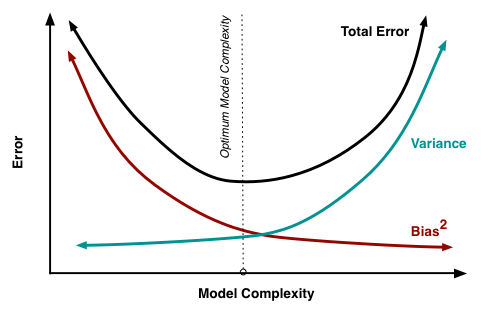